In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Handle missing values
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
df = df.drop(columns=["Cabin", "Name", "Ticket"])

# Features and target
X = df.drop(columns=["Survived"])
y = df["Survived"]

# Categorical and numerical columns
cat_cols = ["Sex", "Embarked"]
num_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    results[name] = {"pipe": pipe, "accuracy": acc, "cm": cm}
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.8045
Decision Tree Accuracy: 0.8212
Random Forest Accuracy: 0.8101


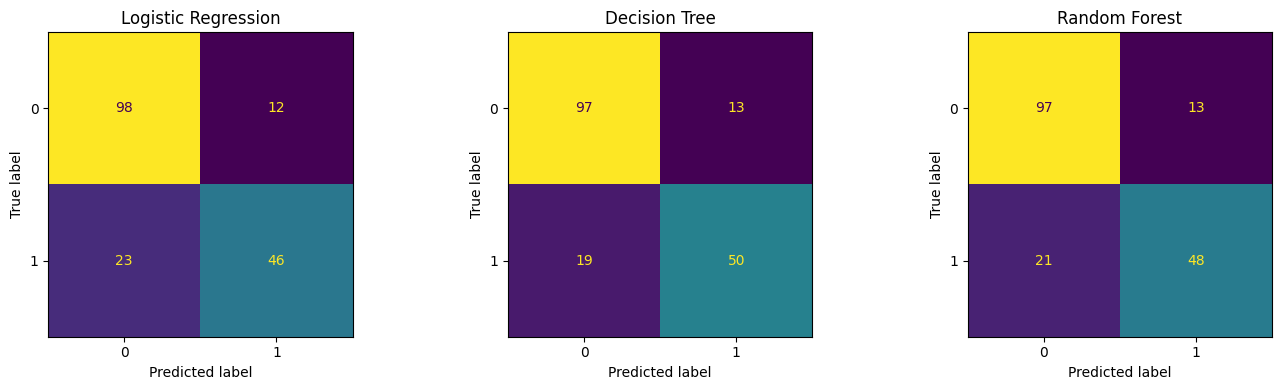

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (name, res) in zip(axes, results.items()):
    disp = ConfusionMatrixDisplay(res["cm"])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [7]:
rf_pipe = results["Random Forest"]["pipe"]

ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = list(cat_features) + num_cols

importances = rf_pipe.named_steps["model"].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
fi.head(10)

Fare          0.264686
Age           0.241086
Sex_female    0.158913
Sex_male      0.129290
Pclass        0.087097
SibSp         0.044902
Parch         0.038327
Embarked_S    0.015513
Embarked_C    0.012889
Embarked_Q    0.007296
dtype: float64

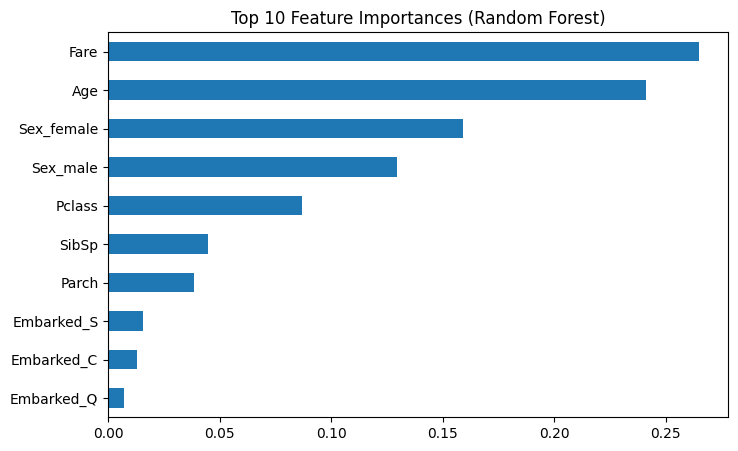

In [8]:
plt.figure(figsize=(8,5))
fi.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [9]:
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5]
}

rf = RandomForestClassifier(random_state=42)

pipe_rf = Pipeline([
    ("prep", preprocess),
    ("model", rf)
])

grid = GridSearchCV(pipe_rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best CV Accuracy: 0.8244453899703341


In [10]:
best_rf = grid.best_estimator_
preds_tuned = best_rf.predict(X_test)

acc_before = results["Random Forest"]["accuracy"]
acc_after = accuracy_score(y_test, preds_tuned)

print("Random Forest Accuracy (Before Tuning):", round(acc_before, 4))
print("Random Forest Accuracy (After Tuning):", round(acc_after, 4))

Random Forest Accuracy (Before Tuning): 0.8101
Random Forest Accuracy (After Tuning): 0.8045
